## Comparing Python Clustering Algorithms
### https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
### https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering Models
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

# Performance Metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import v_measure_score

In [3]:
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [4]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Loadng Data

In [7]:
data = np.load('../../data/clusterable_data.npy')
data

array([[-0.12153499, -0.22876337],
       [-0.22093687, -0.25251088],
       [ 0.1259037 , -0.27314321],
       ...,
       [ 0.50243143, -0.3002958 ],
       [ 0.53822256,  0.19412199],
       [-0.08688887, -0.2092721 ]])

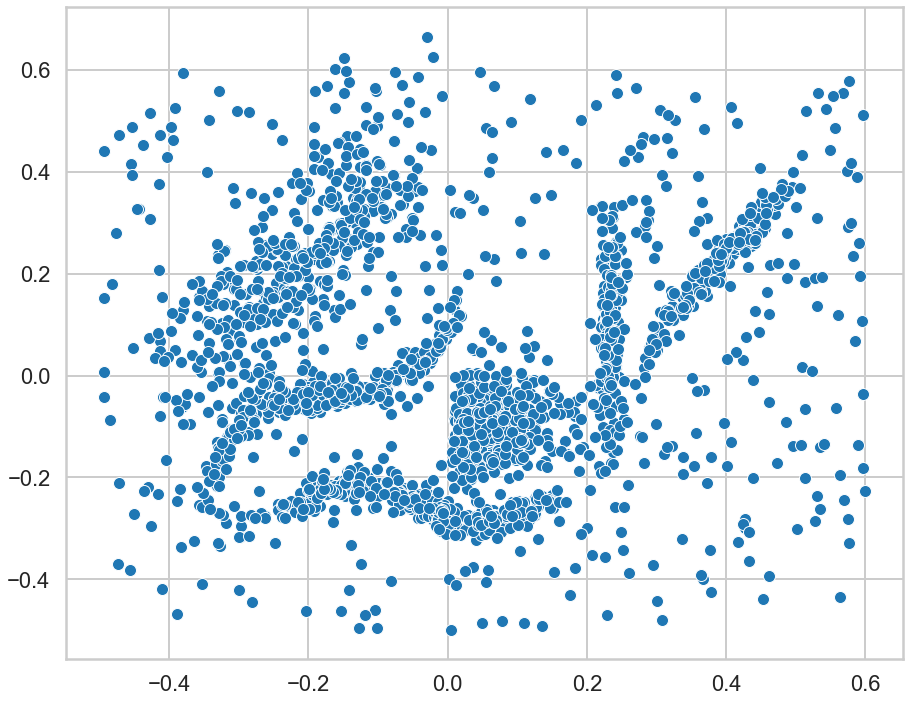

In [8]:
# Plot the Data
plt.figure(figsize=(15,12))
sns.scatterplot(x=data.T[0] ,y=data.T[1], palette=sns.color_palette("hls",10), legend="full")
plt.show()

It's messy, but there are certainly some clusters that you can pick out by eye; determining the exact boundaries of those clusters is harder of course, but we can hope that our clustering algorithms will find at least some of those clusters. So, on to testing

## Testing Clustering Algorithms

### K-Means
K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). K-Means has a few problems however. The first is that it isn't a clustering algorithm, it is a partitioning algorithm. That is to say K-means doesn't 'find clusters' it partitions your dataset into as many (assumed to be globular) chunks as you ask for by attempting to minimize intra-partition distances. That leads to the second problem: you need to specify exactly how many clusters you expect. If you know a lot about your data then that is something you might expect to know. If, on the other hand, you are simply exploring a new dataset then 'number of clusters' is a hard parameter to have any good intuition for. The usually proposed solution is to run K-Means for many different 'number of clusters' values and score each clustering with some 'cluster goodness' measure (usually a variation on intra-cluster vs inter-cluster distances) and attempt to find an 'elbow'.

In [9]:
model = KMeans(n_clusters = 6)
labels = model.fit_predict(data)

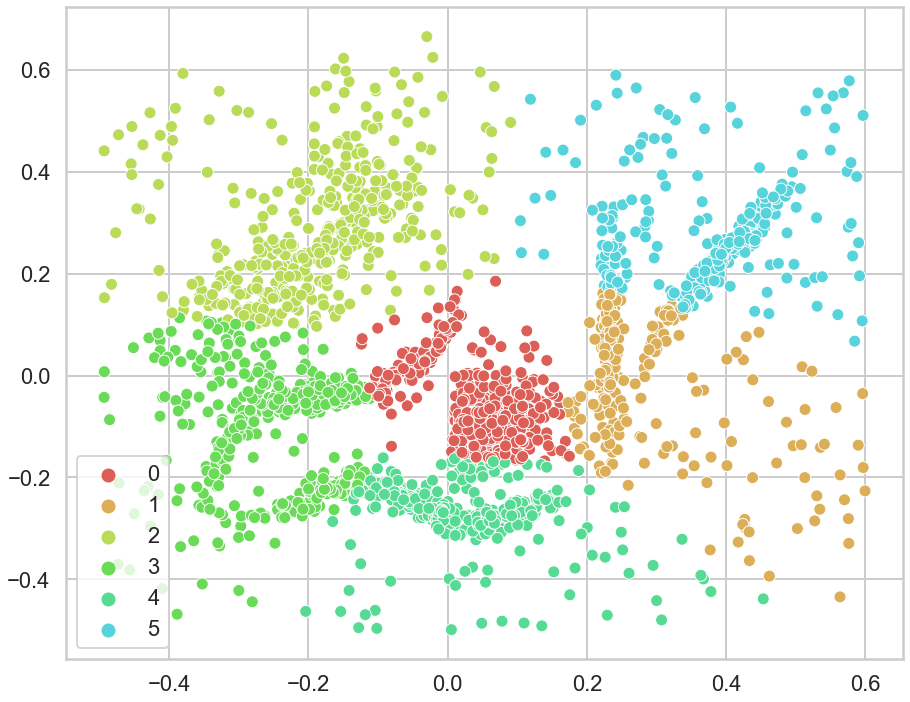

In [10]:
# Plot the Cluster
plt.figure(figsize=(15,12))
sns.scatterplot(x=data.T[0] ,y=data.T[1], hue=labels , palette=sns.color_palette("hls",10), legend="full")
plt.show()

In [20]:
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(data, labels))
print("Silhouette Coefficient:", silhouette_score(data, labels))
print("Homogeneity score:", homogeneity_score(data.T[1], labels))
print("Completeness score:", completeness_score(data.T[1], labels))
print("V measure score:", v_measure_score(data.T[1], labels))

Davies-Bouldin Index: 0.8086382157754316
Silhouette Coefficient: 0.4080350463616284
Homogeneity score: 0.22933437878264487
Completeness score: 1.0000000000000002
V measure score: 0.3731033358226661


## Agglomerative Clustering
Agglomerative clustering is really a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split. More complex variations use things like mean distance between clusters, or distance between cluster centroids etc. to determine which cluster to merge. Once you have a cluster hierarchy you can choose a level or cut (according to some criteria) and take the clusters at that level of the tree. For sklearn we usually choose a cut based on a 'number of clusters' parameter passed in.



In [21]:
model = AgglomerativeClustering(n_clusters = 6, linkage='ward')
labels = model.fit_predict(data)

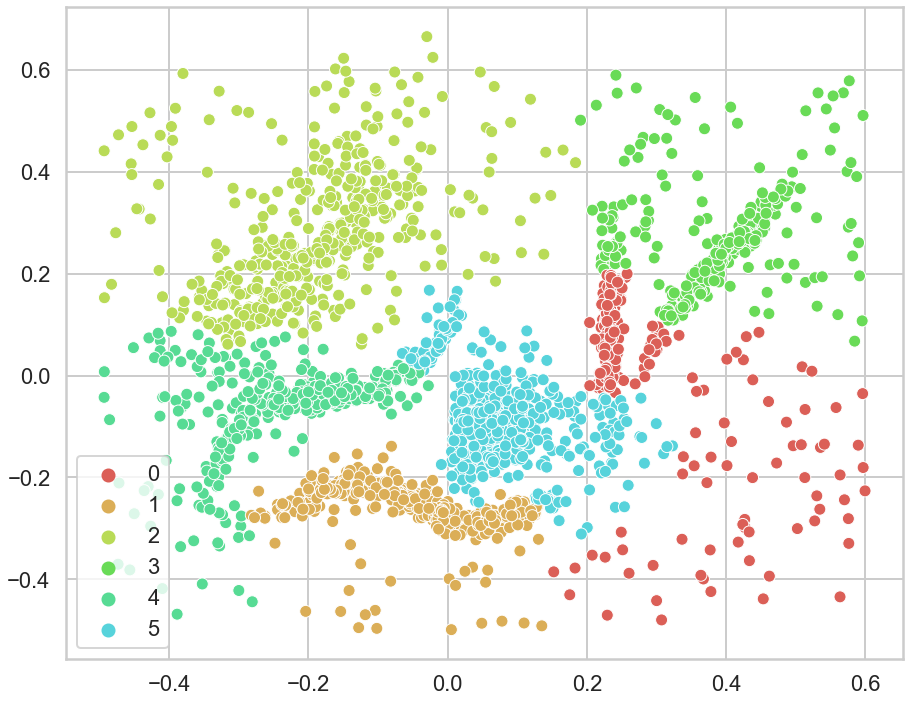

In [22]:
# Plot the Cluster
plt.figure(figsize=(15,12))
sns.scatterplot(x=data.T[0] ,y=data.T[1], hue=labels , palette=sns.color_palette("hls",10), legend="full")
plt.show()

In [23]:
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(data, labels))
print("Silhouette Coefficient:", silhouette_score(data, labels))
print("Homogeneity score:", homogeneity_score(data.T[1], labels))
print("Completeness score:", completeness_score(data.T[1], labels))
print("V measure score:", v_measure_score(data.T[1], labels))

Davies-Bouldin Index: 0.9267060147346524
Silhouette Coefficient: 0.381889583645435
Homogeneity score: 0.22751547024594632
Completeness score: 0.9999999999999999
V measure score: 0.3706926320046477


## DBSCAN
DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or eps in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. This provides several advantages: we get the manifold following behaviour of agglomerative clustering, and we get actual clustering as opposed to partitioning. Better yet, since we can frame the algorithm in terms of local region queries we can use various tricks such as kdtrees to get exceptionally good performance and scale to dataset sizes that are otherwise unapproachable with algorithms other than K-Means. There are some catches however. Obviously epsilon can be hard to pick; you can do some data analysis and get a good guess, but the algorithm can be quite sensitive to the choice of the parameter. The density based transformation depends on another parameter (min_samples in sklearn). Finally the combination of min_samples and eps amounts to a choice of density and the clustering only finds clusters at or above that density; if your data has variable density clusters then DBSCAN is either going to miss them, split them up, or lump some of them together depending on your parameter choices.

In [24]:
model = DBSCAN(eps = 0.025)
labels = model.fit_predict(data)

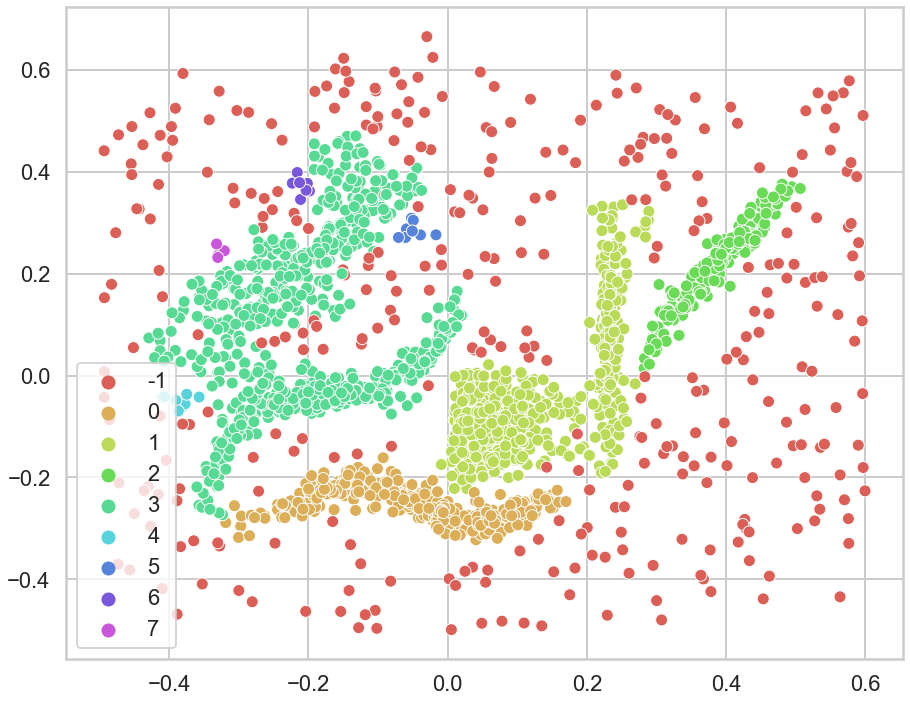

In [25]:
# Plot the Cluster
plt.figure(figsize=(15,12))
sns.scatterplot(x=data.T[0] ,y=data.T[1], hue=labels , palette=sns.color_palette("hls",10), legend="full")
plt.show()

In [26]:
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(data, labels))
print("Silhouette Coefficient:", silhouette_score(data, labels))
print("Homogeneity score:", homogeneity_score(data.T[1], labels))
print("Completeness score:", completeness_score(data.T[1], labels))
print("V measure score:", v_measure_score(data.T[1], labels))

Davies-Bouldin Index: 2.106891043696791
Silhouette Coefficient: 0.014536877002387878
Homogeneity score: 0.20614222176978517
Completeness score: 1.0000000000000002
V measure score: 0.3418207538864041


## Spectral Clustering
Spectral clustering is a method that employs the spectrum of a similarity matrix. The spectrum of a matrix represents the set of its eigenvalues, and a similarity matrix consists of similarity scores between each data point. It reduces the dimensionality of data before clustering. In other words, we can say that spectral clustering creates a graph of data points, and these points are mapped to a lower dimension and separated into clusters.

In [27]:
model = SpectralClustering(n_clusters=6, affinity='rbf', n_init=100, assign_labels='discretize')
labels = model.fit_predict(data)

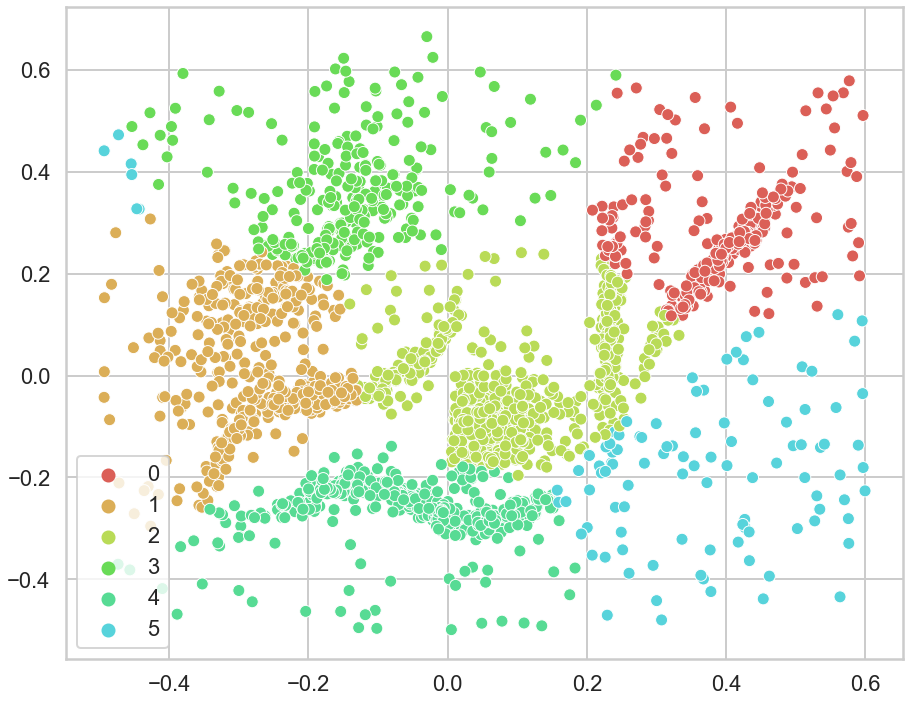

In [28]:
# Plot the Cluster
plt.figure(figsize=(15,12))
sns.scatterplot(x=data.T[0] ,y=data.T[1], hue=labels , palette=sns.color_palette("hls",10), legend="full")
plt.show()

In [29]:
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(data, labels))
print("Silhouette Coefficient:", silhouette_score(data, labels))
print("Homogeneity score:", homogeneity_score(data.T[1], labels))
print("Completeness score:", completeness_score(data.T[1], labels))
print("V measure score:", v_measure_score(data.T[1], labels))

Davies-Bouldin Index: 0.9467810697475922
Silhouette Coefficient: 0.3854852938010052
Homogeneity score: 0.21398531824167083
Completeness score: 1.0
V measure score: 0.3525336180368407


## Affinity Propagation
Affinity Propagation is a newer clustering algorithm that uses a graph based approach to let points 'vote' on their preferred 'exemplar'. The end result is a set of cluster 'exemplars' from which we derive clusters by essentially doing what K-Means does and assigning each point to the cluster of it's nearest exemplar. Affinity Propagation has some advantages over K-Means. First of all the graph based exemplar voting means that the user doesn't need to specify the number of clusters. Second, due to how the algorithm works under the hood with the graph representation it allows for non-metric dissimilarities (i.e. we can have dissimilarities that don't obey the triangle inequality, or aren't symmetric). This second point is important if you are ever working with data isn't naturally embedded in a metric space of some kind; few clustering algorithms support, for example, non-symmetric dissimilarities. Finally Affinity Propagation does, at least, have better stability over runs (but not over parameter ranges!).

In [30]:
model = AffinityPropagation(preference=-5.0, damping=0.95)
labels = model.fit_predict(data)

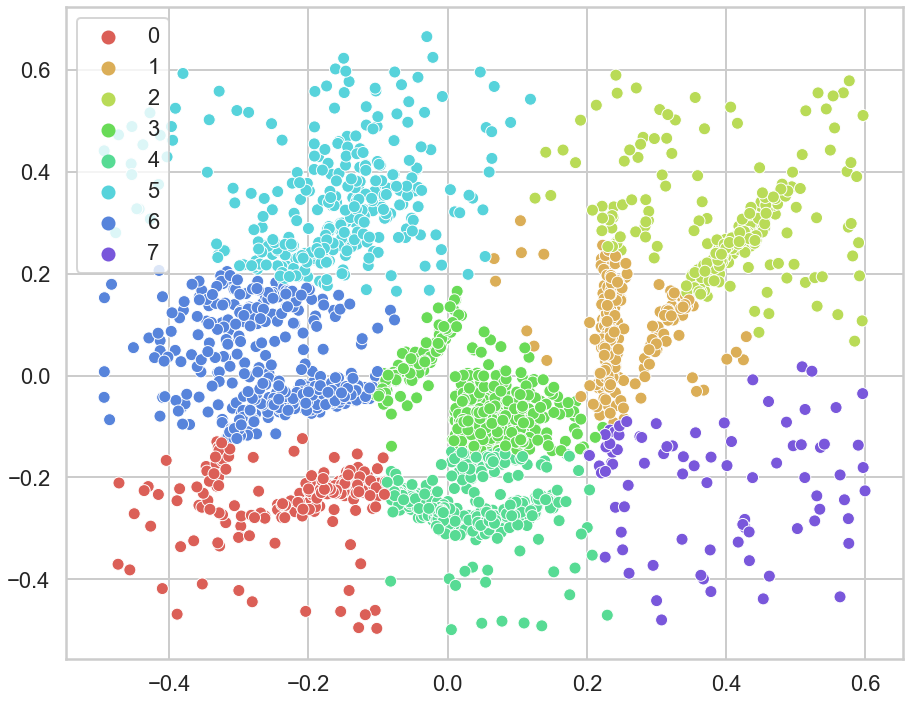

In [31]:
# Plot the Cluster
plt.figure(figsize=(15,12))
sns.scatterplot(x=data.T[0] ,y=data.T[1], hue=labels , palette=sns.color_palette("hls",10), legend="full")
plt.show()

In [32]:
# Calculate internal performance evaluation measures
print("Davies-Bouldin Index:", davies_bouldin_score(data, labels))
print("Silhouette Coefficient:", silhouette_score(data, labels))
print("Homogeneity score:", homogeneity_score(data.T[1], labels))
print("Completeness score:", completeness_score(data.T[1], labels))
print("V measure score:", v_measure_score(data.T[1], labels))

Davies-Bouldin Index: 0.7778356485008953
Silhouette Coefficient: 0.40724867173261176
Homogeneity score: 0.2590139186625068
Completeness score: 1.0000000000000004
V measure score: 0.4114552108171545
